# All python code (as a single .zip package)

This is all the python code required to run the two best-trained models on a test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/NLP/All Python code'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['test_data.csv', 'vectorizer_neg.pkl', 'BERT.pth', 'TFIDF_neg.pkl', 'readme.txt', 'All python code.ipynb']


In [ ]:
# Importing libraries

!pip install transformers
!pip install datasets

import os
import warnings
import string
import re
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word
import spacy

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The two best performing models are
- Model 1: TF-IDF with Next Word Negation (NWN) combined with MNB (after removing stop words).
- Model 2: DistilBERT model.

We first start with testing Model 1.

# Importing test dataset for Model 1

In [ ]:
test_data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'test_data.csv'))
test_data

,text,label
0,lovingly photographed in the manner of a golde...,1
1,consistently clever and suspenseful .,1
2,"it's like a "" big chill "" reunion of the baade...",1
3,the story gives ample opportunity for large-sc...,1
4,"red dragon "" never cuts corners .",1
...,...,...
2127,"this picture is murder by numbers , and as eas...",0
2128,hilarious musical comedy though stymied by acc...,0
2129,"if you are into splatter movies , then you wil...",0
2130,"a dull , simple-minded and stereotypical tale ...",0


# Preprocesssing test dataset

In [ ]:
# Data preprocessing
def clean_text(text):

    # Remove HTML content
    soup = BeautifulSoup(text, 'html.parser')
    # Extract text from  parsed HTML
    text = soup.get_text()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # string.punctuation contains all punctuation characters

    # Convert to lowercase
    text = text.lower()

    # Remove special characters
    # that is not in the range of lowercase letters a-z,
    # uppercase letters A-Z,
    # or whitespace \s.
    pattern=r'[^a-zA-z0-9\s]'
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

In [ ]:
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

<ipython-input-27-b398f30a0d6f>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


# Additional preprocessing

In [ ]:
def remove_stopwords_and_lemmatize(text, lemmatize = False):

    # English stopwords
    stopword_list = stopwords.words('english')

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopword_list]

    if lemmatize: # We can control whether the data is lemmatised or not - for conducting experiments.
        # Initialize WordNet Lemmatizer
        lemmatizer = WordNetLemmatizer()
        filtered_words = [lemmatizer.lemmatize(word.lower()) for word in filtered_words]

    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

In [ ]:
# Remove stop words

import nltk
nltk.download('punkt')
test_data['sw_removed'] = test_data['cleaned_text'].apply(remove_stopwords_and_lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Define the function to modify negation in text - Next Word Negation (NWN)
def handle_negation(text):
    # Define a list of negation words
    negation_words = ['not', 'no', 'never', 'none', 'neither', 'nor', 'cannot']

    # Define a regular expression pattern to match negation words followed by a word
    pattern = r'\b(?:' + '|'.join(negation_words) + r')\b\s+(\w+)'

    # Regular expression to find negation words followed by a word and modify the word
    modified_text = re.sub(pattern, r'not_\1', text)

    return modified_text

In [ ]:
# Handling negation in test_data
test_data['neg_text'] = [handle_negation(text) for text in test_data['cleaned_text']]
test_data['neg_sw_removed'] = test_data['neg_text'].apply(remove_stopwords_and_lemmatize, lemmatize = False)

# Loading pre-trained models

In [ ]:
# Load TF-IDF vectorizer pretrained on training data.
with open(os.path.join(GOOGLE_DRIVE_PATH, 'vectorizer_neg.pkl'), 'rb') as f:
    vectorizer = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Transform the data
X_test = vectorizer.transform(test_data['neg_sw_removed'])
y_test= test_data.label

In [ ]:
# Load the pretrained model (Model 1) from the pickle file
with open(os.path.join(GOOGLE_DRIVE_PATH, 'TFIDF_neg.pkl'), 'rb') as f:
    TFIDF_neg = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Tesing on test set

In [ ]:
# Make predictions on the test set using the best model
y_pred_tfidf = TFIDF_neg.predict(X_test)

Accuracy: 0.7851782363977486
Precision: 0.78520333445984
Recall: 0.7851782363977486
F1-score: 0.7851735101832124


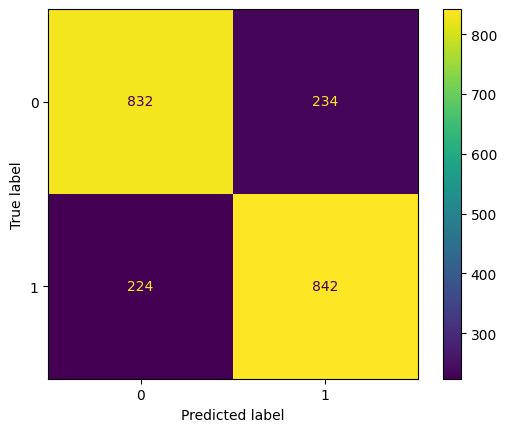

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_tfidf)
print("Accuracy:", accuracy)
# Calculate precision
precision = precision_score(y_test, y_pred_tfidf, average='weighted')
print("Precision:", precision)
# Calculate recall
recall = recall_score(y_test, y_pred_tfidf, average='weighted')
print("Recall:", recall)
# Calculate F1-score
f1= f1_score(y_test, y_pred_tfidf, average='weighted')
print("F1-score:", f1)
# Calculate confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tfidf)
plt.show()

We will move on to testing with Model 2.


# Importing test dataset for Model 2

In [ ]:
# Load the dataset from Huggingface
dataset = load_dataset('rotten_tomatoes')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
# Extract test set
test_dataset = dataset['test']

# Preprocesssing test dataset

In [ ]:
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# tokenize the text data using DistilBERT tokenzier.
def tokenize(batch):
  return tokenizer(batch['text'], padding='max_length', truncation=True, max_length = 500)

# Tokenized data is mapped to dataset
test_dataset = test_dataset.map(tokenize, batched = True)

# Set the data format to 'torch'
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

# Loading pre-trained models

In [ ]:
# Load model architecture
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Define model architecture
class DistilBERTmodel(nn.Module):
    def __init__(self, model):
        super(DistilBERTmodel, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 2)  # Add output layer

    def forward(self, input_ids, attention_mask):
      # input_idf
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(F.relu(self.linear1(last_hidden_state)))
        x = self.linear2(x)
        return F.softmax(x, dim=1)

# Instantiate the model
model = DistilBERTmodel(model)

# Load the saved model
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'BERT.pth')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Ensure the model is on the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTmodel(
  (model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear

# Testing on test set

In [ ]:
# Function to evaluate on test dataset.

def evaluate(model, test_loader, device):
    # Evaluation mode
    model.eval()
    # Initialise variable
    correct, total = 0, 0
    # Initialise list
    all_predictions, all_labels = [], []
    # Track gradients
    with torch.no_grad():
        # Iterate over batches of data
        for batch in test_loader:
            # Retrieves input IDs from batch and moves them to specified device
            input_ids = batch['input_ids'].to(device)
            # Retrieves attention masks from batch and moves them to specified device
            attention_mask = batch['attention_mask'].to(device)
            # Retrieves label from batch and moves them to specified device
            labels = batch['label'].to(device)

            # Obtain model's predictions
            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, dim=1)

            # Store predictions and labels
            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            # Computes accuracy
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = correct / total
    return accuracy, all_predictions, all_labels


In [ ]:
accuracy, predictions, labels = evaluate(model, test_loader, device)

In [ ]:
# Accuracy
accuracy

0.8273921200750469

In [ ]:
from torch.utils.data import Dataset

# Visualse text, labels and predictions
class PredictionsDataset(Dataset):
    def __init__(self, texts, predictions, labels):
        self.texts = texts
        self.predictions = predictions
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'prediction': self.predictions[idx], 'label': self.labels[idx]}

texts = test_dataset['text']
predictions = predictions
labels = labels

# Create the new dataset
predictions_dataset = PredictionsDataset(texts, predictions, labels)
predictions_dataset

In [ ]:
# Printing output
for idx in range(len(predictions_dataset)):
    sample = predictions_dataset[idx]
    print("Text:", sample['text'])
    print("Prediction:", sample['prediction'])
    print("Label:", sample['label'])
    print("-" * 50)


Text: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Prediction: 1
Label: 1
--------------------------------------------------
Text: consistently clever and suspenseful .
Prediction: 1
Label: 1
--------------------------------------------------
Text: it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .
Prediction: 0
Label: 1
--------------------------------------------------
Text: the story gives ample opportunity for large-scale action and suspense , which director shekhar kapur supplies with tremendous skill .
Prediction: 1
Label: 1
--------------------------------------------------
Text: red dragon " never cuts corners .
Prediction: 1
Label: 1
--------------------------------------------------
Text: fresnadillo has something serious to say about the ways in which extravagant chance can distort our perspective and thro